In [1]:
!pip install GEOparse
!pip install anndata
!pip install numcodecs

In [1]:
import GEOparse
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from prob.progression import Progression_Inference
from prob.ode_bayesian_lasso import ODE_BayesianLasso
from prob.preprocessing import load_GSE48350, select_genes, filter_and_normalize

In [2]:
# Load & preprocess
prob_input = load_GSE48350()
prob_input_selected, genes_of_interest = select_genes(prob_input)
prob_input_normalized = filter_and_normalize(prob_input_selected)

# Step 1: pseudotime inference
Data_ordered_real, PPD_real, TimeSampled_real = Progression_Inference(prob_input_normalized)
# Step 2: network inference
Para_Post_real, S_real, AM_real = ODE_BayesianLasso(Data_ordered_real, TimeSampled_real)

16-Dec-2025 12:42:23 DEBUG utils - Directory ./data already exists. Skipping.
16-Dec-2025 12:42:23 INFO GEOparse - File already exist: using local version.
16-Dec-2025 12:42:23 INFO GEOparse - Parsing ./data\GSE48350_family.soft.gz: 
16-Dec-2025 12:42:23 DEBUG GEOparse - DATABASE: GeoMiame
16-Dec-2025 12:42:23 DEBUG GEOparse - SERIES: GSE48350
16-Dec-2025 12:42:23 DEBUG GEOparse - PLATFORM: GPL570


📥 Downloading GSE48350 from GEO...


C:\Users\belda\anaconda3\Lib\site-packages\GEOparse\GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
16-Dec-2025 12:42:26 DEBUG GEOparse - SAMPLE: GSM300166
16-Dec-2025 12:42:27 DEBUG GEOparse - SAMPLE: GSM300167
16-Dec-2025 12:42:27 DEBUG GEOparse - SAMPLE: GSM300168
16-Dec-2025 12:42:27 DEBUG GEOparse - SAMPLE: GSM300169
16-Dec-2025 12:42:28 DEBUG GEOparse - SAMPLE: GSM300170
16-Dec-2025 12:42:28 DEBUG GEOparse - SAMPLE: GSM300171
16-Dec-2025 12:42:28 DEBUG GEOparse - SAMPLE: GSM300172
16-Dec-2025 12:42:28 DEBUG GEOparse - SAMPLE: GSM300173
16-Dec-2025 12:42:29 DEBUG GEOparse - SAMPLE: GSM300174
16-Dec-2025 12:42:29 DEBUG GEOparse - SAMPLE: GSM300175
16-Dec-2025 12:42:29 DEBUG GEOparse - SAMPLE: GSM300176
16-Dec-2025 12:42:29 DEBUG GEOparse - SAMPLE: GSM300177
16-Dec-2025 12:42:29 DEBUG GEOparse - SAMPLE: GSM300178
16-Dec-2025 12:42:30 DEBUG GEOparse - SAMPL

Expression matrix shape (probes x samples): (54675, 253)
Metadata shape: (253, 7)
Metadata columns: ['individual', 'brain region', 'gender', 'age (yrs)', 'braak stage', 'apoe genotype', 'mmse']
Fetching GPL570 annotation...


C:\Users\belda\anaconda3\Lib\site-packages\GEOparse\GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


Collapsed to gene-level expression: (23520, 253)

Selected top 20 genes by variance:
  1. CLU (variance: 2.95)
  2. MS4A6A (variance: 2.26)
  3. TREM2 (variance: 1.71)
  4. TYROBP (variance: 0.88)
  5. MEF2C (variance: 0.74)
  6. CD33 (variance: 0.49)
  7. INPP5D (variance: 0.29)
  8. SLC24A4 (variance: 0.25)
  9. PTK2B (variance: 0.24)
  10. APOE (variance: 0.24)
  11. FERMT2 (variance: 0.23)
  12. BACE1 (variance: 0.23)
  13. ABCA7 (variance: 0.22)
  14. BIN1 (variance: 0.15)
  15. ZCWPW1 (variance: 0.14)
  16. GSK3B (variance: 0.13)
  17. PSEN1 (variance: 0.12)
  18. NOTCH3 (variance: 0.11)
  19. ADAM10 (variance: 0.11)
  20. PSEN2 (variance: 0.07)

Initial PROB input matrix shape: (21, 253) (20 genes x 253 samples)

✓ Expression data normalized (z-score)
  Mean per gene: [-4.10619251e-16  4.01639506e-16  6.53072367e-18] ... (should be ~0)
  Std per gene: [1. 1. 1.] ... (should be ~1)

Final PROB input matrix shape: (21, 68)

Step 2: GRN Inference
✓ Step 2 complete: 27 edges (confid

## FIGURES

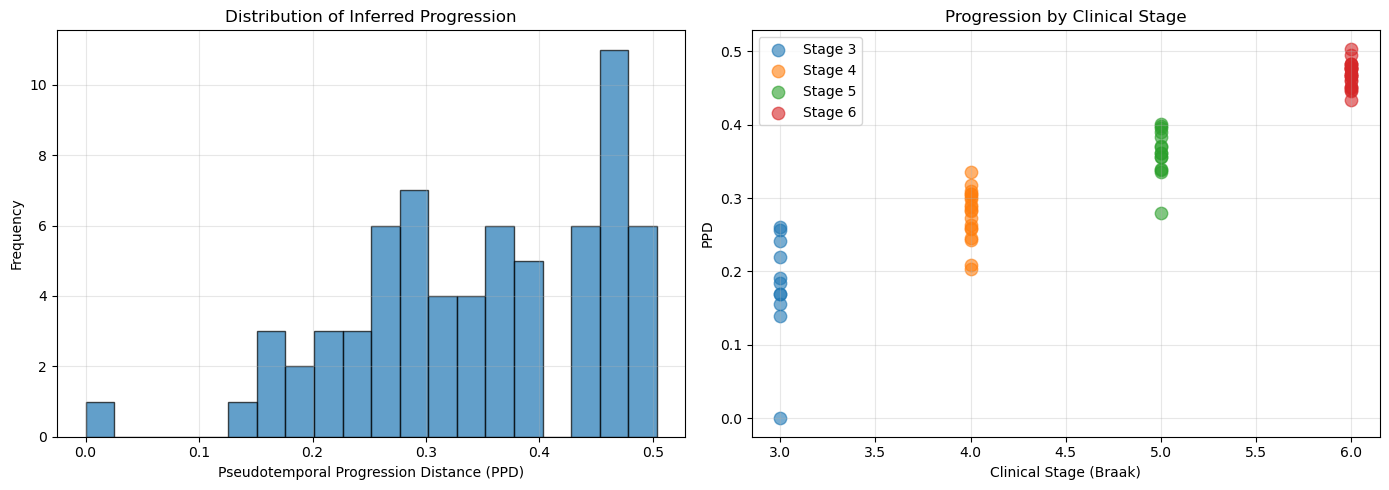

In [29]:
# PPD histogram and Stage vs PPD
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PPD histogram
ax = axes[0]
ax.hist(PPD_real, bins=20, alpha=0.7, edgecolor='black')
ax.set_xlabel('Pseudotemporal Progression Distance (PPD)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Inferred Progression')
ax.grid(True, alpha=0.3)

# Stage distribution scatter
ax = axes[1]
stages = prob_input_normalized[-1, :].astype(int)
for stage in np.unique(stages):
    mask = stages == stage
    ax.scatter([stage]*np.sum(mask), PPD_real[mask], label=f'Stage {stage}', alpha=0.6, s=80)
ax.set_xlabel('Clinical Stage (Braak)')
ax.set_ylabel('PPD')
ax.set_title('Progression by Clinical Stage')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# Check sample distribution and data quality
print("="*60)
print("DIAGNOSTICS")
print("="*60)

# Sample counts per stage
stages = prob_input_normalized[-1, :]
print("\nSample counts by Braak stage:")
for stage in sorted(np.unique(stages)):
    count = np.sum(stages == stage)
    pct = 100 * count / len(stages)
    print(f"  Stage {int(stage)}: {count:3d} samples ({pct:5.1f}%)")

print(f"\nTotal samples: {len(stages)}")

# PPD statistics by stage
print("\nPPD statistics by stage:")
print(f"{'Stage':<8} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Range':<8}")
print("-" * 56)
for stage in sorted(np.unique(stages)):
    mask = stages == stage
    ppd_subset = PPD_real[mask]
    print(f"{int(stage):<8} {np.mean(ppd_subset):<8.3f} {np.std(ppd_subset):<8.3f} "
          f"{np.min(ppd_subset):<8.3f} {np.max(ppd_subset):<8.3f} {np.max(ppd_subset)-np.min(ppd_subset):<8.3f}")

# Network statistics
print(f"\nNetwork statistics:")
print(f"  Total possible edges: {len(genes_of_interest) * (len(genes_of_interest) - 1)}")
print(f"  Detected edges (P>0.95): {np.sum(AM_real != 0)}")
print(f"  Network density: {100 * np.sum(AM_real != 0) / (len(genes_of_interest) * (len(genes_of_interest) - 1)):.2f}%")

# Top regulators
out_degrees = np.sum(AM_real != 0, axis=1)
print(f"\nTop 5 regulators (genes with most outgoing edges):")
top_indices = np.argsort(out_degrees)[::-1][:5]
for idx in top_indices:
    if out_degrees[idx] > 0:
        print(f"  {genes_of_interest[idx]}: {int(out_degrees[idx])} outgoing edges")

# Correlation between PPD and Braak stage
from scipy.stats import spearmanr
corr, pval = spearmanr(stages, PPD_real)
print(f"\nPPD vs Braak Stage correlation:")
print(f"  Spearman r = {corr:.4f}")
print(f"  p-value = {pval:.2e}")
if corr > 0.7:
    print(f"  ✓ Strong positive correlation")
elif corr > 0.4:
    print(f"  ~ Moderate positive correlation")
else:
    print(f"  ✗ Weak correlation - PPD may not capture progression well")

print("="*60)

DIAGNOSTICS

Sample counts by Braak stage:
  Stage 3:  11 samples ( 16.2%)
  Stage 4:  19 samples ( 27.9%)
  Stage 5:  15 samples ( 22.1%)
  Stage 6:  23 samples ( 33.8%)

Total samples: 68

PPD statistics by stage:
Stage    Mean     Std      Min      Max      Range   
--------------------------------------------------------
3        0.181    0.069    0.000    0.261    0.261   
4        0.277    0.034    0.203    0.335    0.132   
5        0.362    0.031    0.279    0.400    0.121   
6        0.468    0.016    0.434    0.503    0.069   

Network statistics:
  Total possible edges: 380
  Detected edges (P>0.95): 27
  Network density: 7.11%

Top 5 regulators (genes with most outgoing edges):
  TYROBP: 6 outgoing edges
  APOE: 4 outgoing edges
  MS4A6A: 3 outgoing edges
  CLU: 3 outgoing edges
  GSK3B: 2 outgoing edges

PPD vs Braak Stage correlation:
  Spearman r = 0.9452
  p-value = 8.55e-34
  ✓ Strong positive correlation


In [33]:
print("="*60)
print("EDGE COUNT AT DIFFERENT CONFIDENCE THRESHOLDS")
print("="*60)

# Test different thresholds
thresholds = [0.99, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70]

print(f"\n{'Threshold':<12} {'Edges':<8} {'Density':<10}")
print("-" * 32)

for thresh in thresholds:
    edge_count = np.sum(S_real > thresh)
    density = 100 * edge_count / (len(genes_of_interest) * (len(genes_of_interest) - 1))
    print(f"P > {thresh:<6.2f}   {edge_count:<8} {density:<8.2f}%")

print("\nRecommendation: Aim for 20-60 edges (5-15% density)")
print("="*60)

EDGE COUNT AT DIFFERENT CONFIDENCE THRESHOLDS

Threshold    Edges    Density   
--------------------------------
P > 0.99     1        0.26    %
P > 0.95     2        0.53    %
P > 0.90     8        2.11    %
P > 0.85     12       3.16    %
P > 0.80     16       4.21    %
P > 0.75     27       7.11    %
P > 0.70     35       9.21    %

Recommendation: Aim for 20-60 edges (5-15% density)


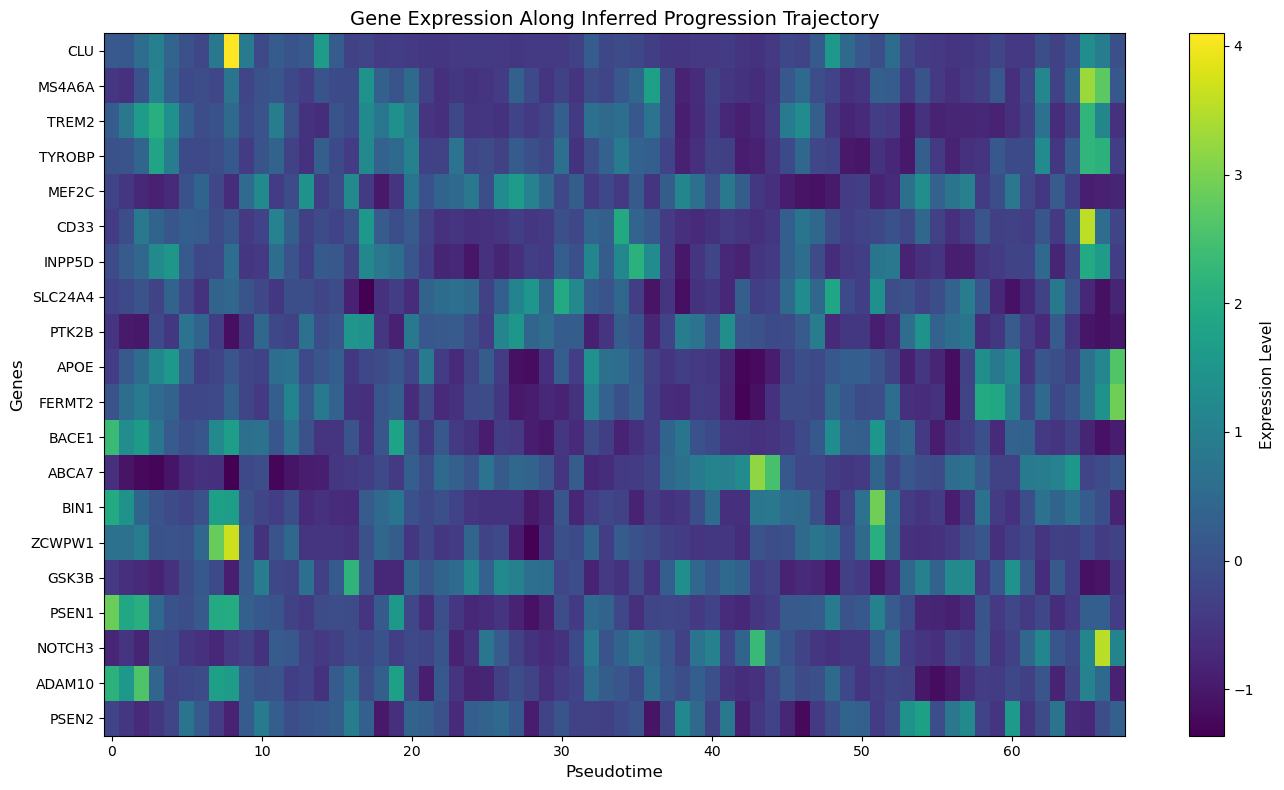

In [35]:

# Gene Expression Heatmap Along Progression
fig, ax = plt.subplots(figsize=(14, 8))

# Plot heatmap of smoothed data
im = ax.imshow(Data_ordered_real, aspect='auto', cmap='viridis')
ax.set_xlabel('Pseudotime', fontsize=12)
ax.set_ylabel('Genes', fontsize=12)
ax.set_title('Gene Expression Along Inferred Progression Trajectory', fontsize=14)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Expression Level', fontsize=11)

# Set y-axis labels with actual gene names
ax.set_yticks(np.arange(Data_ordered_real.shape[0]))
ax.set_yticklabels(genes_of_interest, fontsize=10)

plt.tight_layout()
plt.show()

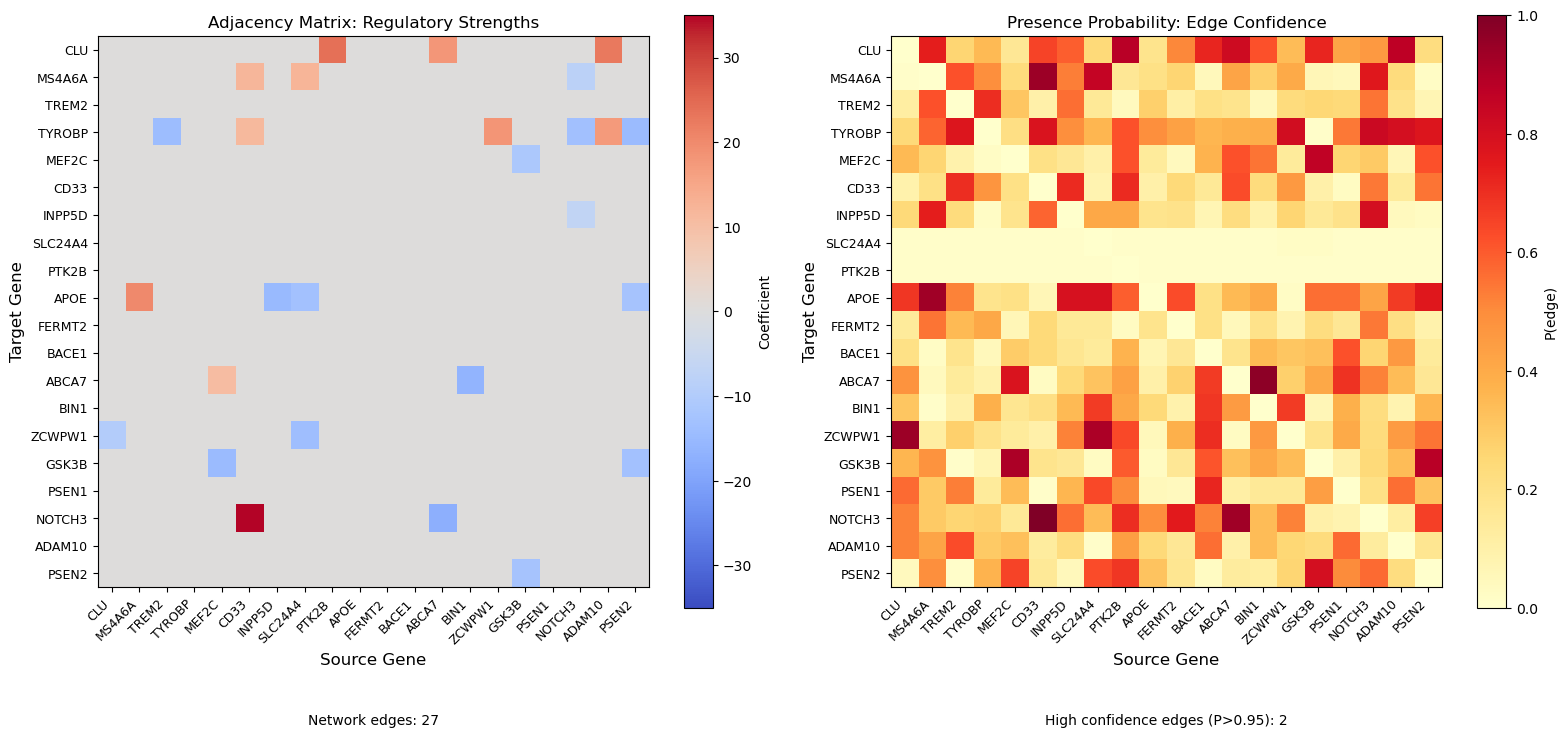

In [37]:
# Inferred Gene Regulatory Network
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Adjacency matrix (AM)
ax = axes[0]
vmax = np.max(np.abs(AM_real))
im1 = ax.imshow(AM_real, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)
ax.set_title('Adjacency Matrix: Regulatory Strengths', fontsize=12)

# Set tick labels with actual gene names
ax.set_xticks(np.arange(len(genes_of_interest)))
ax.set_yticks(np.arange(len(genes_of_interest)))
ax.set_xticklabels(genes_of_interest, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(genes_of_interest, fontsize=9)

cbar1 = plt.colorbar(im1, ax=ax)
cbar1.set_label('Coefficient', fontsize=10)
n_edges = np.sum(AM_real != 0)
ax.text(0.5, -0.25, f'Network edges: {n_edges}', transform=ax.transAxes, ha='center')

# Presence probability (S)
ax = axes[1]
im2 = ax.imshow(S_real, cmap='YlOrRd', vmin=0, vmax=1)
ax.set_xlabel('Source Gene', fontsize=12)
ax.set_ylabel('Target Gene', fontsize=12)
ax.set_title('Presence Probability: Edge Confidence', fontsize=12)

# Set tick labels with actual gene names
ax.set_xticks(np.arange(len(genes_of_interest)))
ax.set_yticks(np.arange(len(genes_of_interest)))
ax.set_xticklabels(genes_of_interest, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(genes_of_interest, fontsize=9)

cbar2 = plt.colorbar(im2, ax=ax)
cbar2.set_label('P(edge)', fontsize=10)
high_conf = np.sum(S_real > 0.95)
ax.text(0.5, -0.25, f'High confidence edges (P>0.95): {high_conf}', transform=ax.transAxes, ha='center')

plt.tight_layout()
plt.show()

C:\Users\belda\AppData\Local\Temp\ipykernel_23196\2123470988.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', fontsize=12)


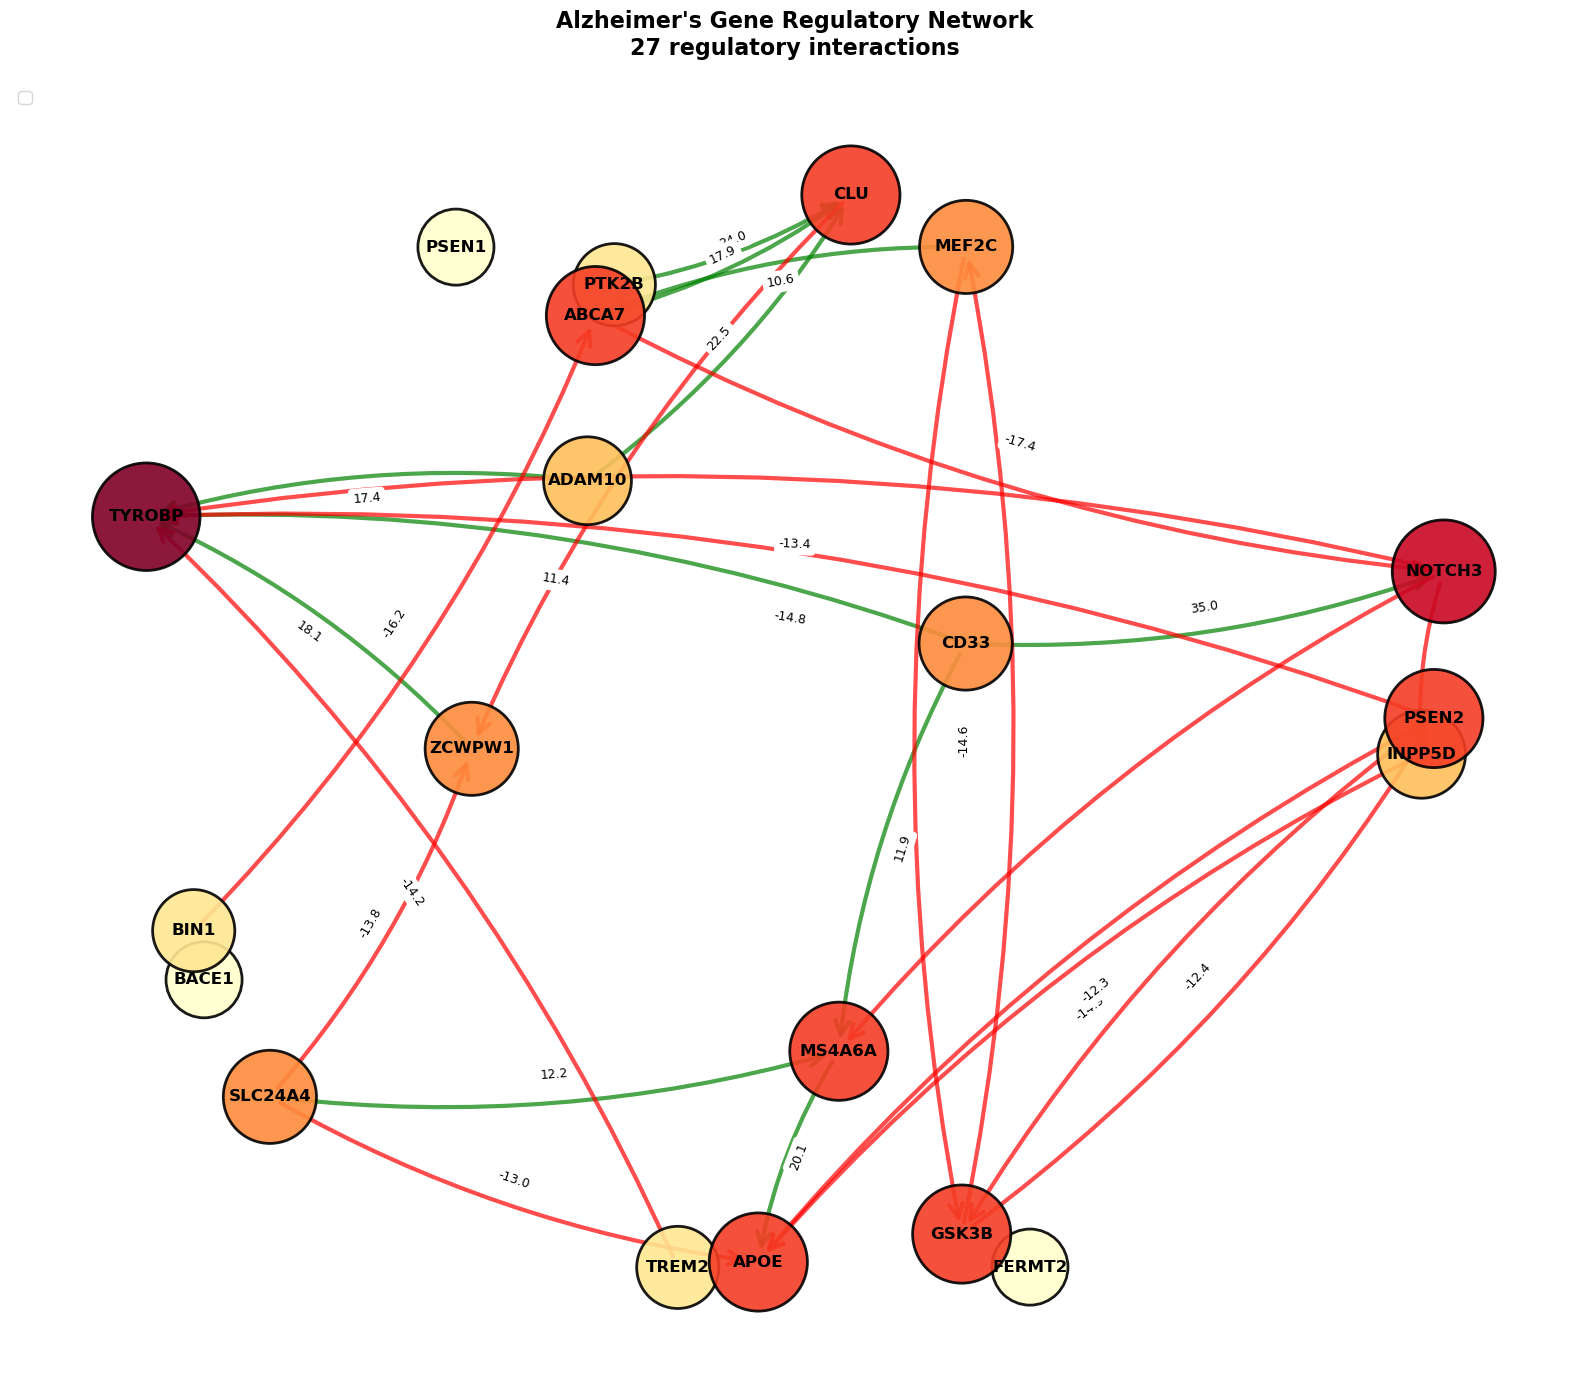

NETWORK SUMMARY

Total nodes (genes): 20
Total edges: 27
  Activation (green): 11
  Inhibition (red): 16

Network density: 0.071
Average degree: 2.70

Top 5 regulators (out-degree):
  CD33: 3 targets → MS4A6A, TYROBP, NOTCH3
  SLC24A4: 3 targets → MS4A6A, APOE, ZCWPW1
  NOTCH3: 3 targets → MS4A6A, TYROBP, INPP5D
  PSEN2: 3 targets → TYROBP, APOE, GSK3B
  MEF2C: 2 targets → ABCA7, GSK3B

Top 5 regulated genes (in-degree):
  TYROBP: 6 regulators ← TREM2, CD33, ZCWPW1, NOTCH3, ADAM10, PSEN2
  APOE: 4 regulators ← MS4A6A, INPP5D, SLC24A4, PSEN2
  CLU: 3 regulators ← PTK2B, ABCA7, ADAM10
  MS4A6A: 3 regulators ← CD33, SLC24A4, NOTCH3
  ABCA7: 2 regulators ← MEF2C, BIN1


In [39]:
import networkx as nx

# Create directed graph from adjacency matrix
G = nx.DiGraph()

# Add all genes as nodes
for gene in genes_of_interest:
    G.add_node(gene)

# Add edges with weights
edge_list = []
for i, gene_target in enumerate(genes_of_interest):
    for j, gene_source in enumerate(genes_of_interest):
        if AM_real[i, j] != 0:
            G.add_edge(gene_source, gene_target, weight=AM_real[i, j])
            edge_list.append((gene_source, gene_target, AM_real[i, j]))

# Separate edges by sign (activation vs inhibition)
pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]
neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 0]

# Create figure
fig, ax = plt.subplots(figsize=(16, 14))

# Layout - use spring layout with more iterations for better spacing
pos = nx.spring_layout(G, k=3, iterations=100, seed=42)

# Draw nodes with size based on degree
node_degrees = dict(G.degree())
node_sizes = [3000 + node_degrees[node] * 500 for node in G.nodes()]
node_colors = [node_degrees[node] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                       cmap='YlOrRd', alpha=0.9, edgecolors='black', 
                       linewidths=2, ax=ax)

# Draw edges with different colors
if len(pos_edges) > 0:
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color='green',
                          width=3, alpha=0.7, arrows=True, arrowsize=25,
                          arrowstyle='->', connectionstyle='arc3,rad=0.1',
                          ax=ax, label='Activation')

if len(neg_edges) > 0:
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color='red',
                          width=3, alpha=0.7, arrows=True, arrowsize=25,
                          arrowstyle='->', connectionstyle='arc3,rad=0.1',
                          ax=ax, label='Inhibition')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold',
                        font_family='sans-serif', ax=ax)

# Add edge weight labels for strong interactions
edge_labels = {}
for u, v, w in edge_list:
    if abs(w) > 10:  # Only label strong edges
        edge_labels[(u, v)] = f'{w:.1f}'

if edge_labels:
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, ax=ax)

ax.set_title(f'Alzheimer\'s Gene Regulatory Network\n{len(G.edges())} regulatory interactions', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12)
ax.axis('off')

plt.tight_layout()
plt.show()

print('='*60)
print('NETWORK SUMMARY')
print('='*60)
print(f'\nTotal nodes (genes): {len(G.nodes())}')
print(f'Total edges: {len(G.edges())}')
print(f'  Activation (green): {len(pos_edges)}')
print(f'  Inhibition (red): {len(neg_edges)}')
print(f'\nNetwork density: {nx.density(G):.3f}')
print(f'Average degree: {sum(dict(G.degree()).values()) / len(G.nodes()):.2f}')

print(f'\nTop 5 regulators (out-degree):')
out_deg = dict(G.out_degree())
for gene, deg in sorted(out_deg.items(), key=lambda x: x[1], reverse=True)[:5]:
    if deg > 0:
        targets = list(G.successors(gene))
        print(f'  {gene}: {deg} targets → {", ".join(targets)}')

print(f'\nTop 5 regulated genes (in-degree):')
in_deg = dict(G.in_degree())
for gene, deg in sorted(in_deg.items(), key=lambda x: x[1], reverse=True)[:5]:
    if deg > 0:
        sources = list(G.predecessors(gene))
        print(f'  {gene}: {deg} regulators ← {", ".join(sources)}')

print('='*60)